# This code based on these codes.
https://www.kaggle.com/francksylla/titanic/titanic-machine-learning-from-disaster/code


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display
%matplotlib inline

train_input = pd.read_csv("../input/train.csv", dtype={"Age": np.float64})
test_input = pd.read_csv("../input/test.csv", dtype={"Age": np.float64})

df = pd.concat([train_input, test_input], ignore_index=True)
df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


[[<matplotlib.axes._subplots.AxesSubplot object at 0x05361350>


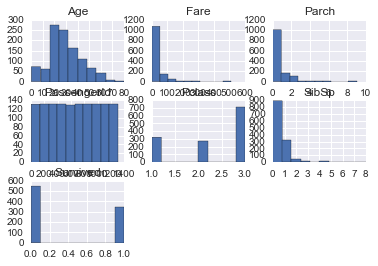

In [2]:
print(df.hist())

In [3]:
categorical_columns = ['Sex', 'Embarked']
numerical_columns = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
text_columns = ['Name', 'Ticket']

def category_to_numeric(df, column_name):
    for category in df[column_name].unique():
        category_column = column_name + '_' + str(category)
        if category_column in df.columns:
            df = df.drop(category_column, axis=1)
        if category_column not in numerical_columns:
            numerical_columns.append(category_column)
    df= pd.concat([df,pd.get_dummies(df[column_name], prefix=column_name)],axis=1)
    return df

[[<matplotlib.axes._subplots.AxesSubplot object at 0x127F0310>


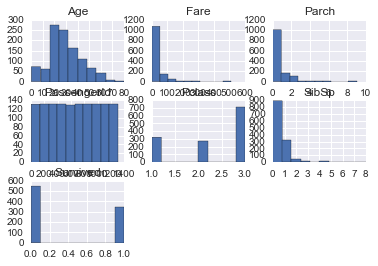

In [4]:
print(df.hist())

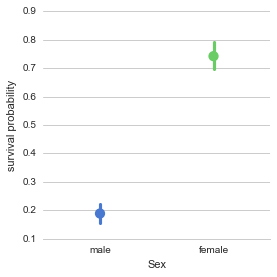

In [5]:
# Sex
sns.set(style="whitegrid")

g = sns.factorplot(x="Sex", y="Survived", data=df, size=4, palette="muted")
g.despine(left=True)
g.set_ylabels("survival probability")

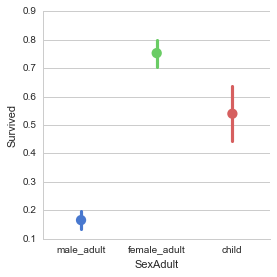

In [6]:
def get_sex_adult(row):
    age, sex = row
    if age < 18:
        return 'child'
    elif sex == 'female':
        return 'female_adult'
    else:
        return 'male_adult'

df['SexAdult'] = df[['Age', 'Sex']].apply(get_sex_adult, axis=1)
g = sns.factorplot(x="SexAdult", y="Survived", data=df, size=4, palette="muted")

if 'SexAdult' not in categorical_columns:
    categorical_columns.append('SexAdult')

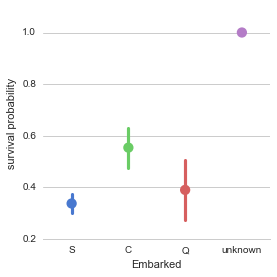

In [7]:
# Embarked
df['Embarked'] = df['Embarked'].fillna('unknown')
g = sns.factorplot(x="Embarked", y="Survived", data=df, size=4, palette="muted")
g.despine(left=True)
g.set_ylabels("survival probability")

if 'Embarked' not in categorical_columns:
    categorical_columns.append('Embarked')

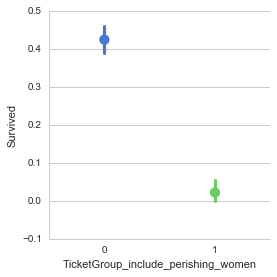

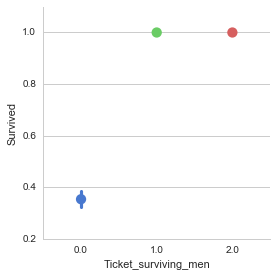

In [8]:
df_ticket = pd.DataFrame(df['Ticket'].value_counts())
df_ticket.rename(columns={'Ticket':'TicketMembers'}, inplace=True)

df_ticket['Ticket_perishing_women'] = df.Ticket[(df.SexAdult == 'female_adult')
                                               & (df.Survived == 0.0)
                                               & ((df.Parch > 0) | (df.SibSp > 0))].value_counts()
df_ticket['Ticket_perishing_women'] = df_ticket['Ticket_perishing_women'].fillna(0)
df_ticket['TicketGroup_include_perishing_women'] = df_ticket['Ticket_perishing_women'] > 0
df_ticket['TicketGroup_include_perishing_women'] = df_ticket['TicketGroup_include_perishing_women'].astype(int)

df_ticket['Ticket_surviving_men'] = df.Ticket[(df.SexAdult == 'male_adult')
                                              & (df.Survived == 1.0)
                                              & ((df.Parch > 0) | (df.SibSp > 0))].value_counts()
df_ticket['Ticket_surviving_men'] = df_ticket['Ticket_surviving_men'].fillna(0)
df_ticket['TicketGroup_include_surviving_men'] = df_ticket['Ticket_surviving_men'] > 0
df_ticket['TicketGroup_include_surviving_men'] = df_ticket['TicketGroup_include_surviving_men'].astype(int)

df_ticket["TicketId"] = pd.Categorical.from_array(df_ticket.index).codes
df_ticket.loc[df_ticket[df_ticket['TicketMembers'] < 3].index, "TicketId"] = -1
df_ticket["TicketMembers_Simple"] = pd.cut(df_ticket['TicketMembers'], bins=[0,1,4,20], labels=[0,1,2])
if 'TicketGroup_include_perishing_women' not in df.columns:
    df = pd.merge(df, df_ticket, left_on="Ticket", right_index=True, how='left', sort=False)

if 'Ticket_perishing_women' not in numerical_columns:
    numerical_columns.append('Ticket_perishing_women')
if 'TicketGroup_include_perishing_women' not in numerical_columns:
    numerical_columns.append('TicketGroup_include_perishing_women')
if 'Ticket_surviving_men' not in numerical_columns:
    numerical_columns.append('Ticket_surviving_men')
if 'TicketGroup_include_surviving_men' not in numerical_columns:
    numerical_columns.append('TicketGroup_include_surviving_men')
if 'TicketId' not in numerical_columns:
    numerical_columns.append('TicketId')
if 'TicketMembers' not in numerical_columns:
    numerical_columns.append('TicketMembers')
    
g = sns.factorplot(x="TicketGroup_include_perishing_women", y="Survived", data=df, size=4, palette="muted")
g = sns.factorplot(x="Ticket_surviving_men", y="Survived", data=df, size=4, palette="muted")

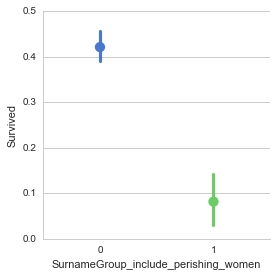

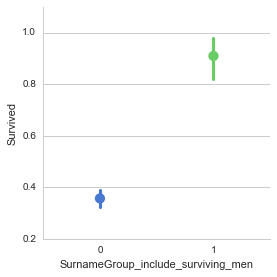

In [9]:
# surname
df['surname'] = df['Name'].apply(lambda x: x.split(',')[0].lower())
df_surname = pd.DataFrame(df['surname'].value_counts())
df_surname.rename(columns={'surname':'SurnameMembers'}, inplace=True)

df_surname['Surname_perishing_women'] = df.surname[(df.SexAdult == 'female_adult')
                                               & (df.Survived == 0.0)
                                               & ((df.Parch > 0) | (df.SibSp > 0))].value_counts()
df_surname['Surname_perishing_women'] = df_surname['Surname_perishing_women'].fillna(0)
df_surname['SurnameGroup_include_perishing_women'] = df_surname['Surname_perishing_women'] > 0
df_surname['SurnameGroup_include_perishing_women'] = df_surname['SurnameGroup_include_perishing_women'].astype(int)

df_surname['Surname_surviving_men'] = df.surname[(df.SexAdult == 'male_adult')
                                              & (df.Survived == 1.0)
                                              & ((df.Parch > 0) | (df.SibSp > 0))].value_counts()
df_surname['Surname_surviving_men'] = df_surname['Surname_surviving_men'].fillna(0)
df_surname['SurnameGroup_include_surviving_men'] = df_surname['Surname_surviving_men'] > 0
df_surname['SurnameGroup_include_surviving_men'] = df_surname['SurnameGroup_include_surviving_men'].astype(int)

df_surname["SurnameId"] = pd.Categorical.from_array(df_surname.index).codes
df_surname.loc[df_surname[df_surname['SurnameMembers'] < 3].index, "SurnameId"] = -1
df_surname["SurnameMembers_Simple"] = pd.cut(df_surname['SurnameMembers'], bins=[0,1,4,20], labels=[0,1,2])
if 'SurnameGroup_include_perishing_women' not in df.columns:
    df = pd.merge(df, df_surname, left_on="surname", right_index=True, how='left', sort=False)


if 'Surname_perishing_women' not in numerical_columns:
    numerical_columns.append('Surname_perishing_women')
if 'SurnameGroup_include_perishing_women' not in numerical_columns:
    numerical_columns.append('SurnameGroup_include_perishing_women')
if 'Surname_surviving_men' not in numerical_columns:
    numerical_columns.append('Surname_surviving_men')
if 'SurnameGroup_include_surviving_men' not in numerical_columns:
    numerical_columns.append('SurnameGroup_include_surviving_men')
if 'SurnameId' not in numerical_columns:
    numerical_columns.append('SurnameId')
if 'SurnameMembers' not in numerical_columns:
    numerical_columns.append('SurnameMembers')
    
g = sns.factorplot(x="SurnameGroup_include_perishing_women", y="Survived", data=df, size=4, palette="muted")
g = sns.factorplot(x="SurnameGroup_include_surviving_men", y="Survived", data=df, size=4, palette="muted")

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Major' 'Lady' 'Sir'
 'Mlle' 'Col' 'Capt' 'Countess' 'Jonkheer' 'Dona']


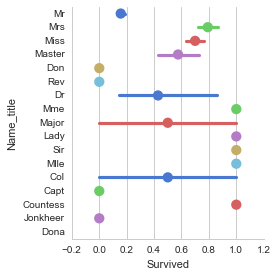

In [10]:
# title
import re
df['Name_title'] = df['Name'].apply(lambda x: re.search(' ([A-Za-z]+)\.', x).group(1))
df.loc[df[df['Name_title'] == 'Ms'].index, 'Name_title'] = 'Miss'
print(df['Name_title'].unique())
if 'Name_title' not in categorical_columns:
    categorical_columns.append('Name_title')
g = sns.factorplot(y="Name_title", x="Survived", data=df, size=4, palette="muted")

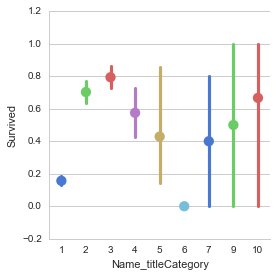

In [107]:
title_mapping = {
    "Mr": 1, 
    "Miss": 2, 
    "Ms": 2, 
    "Mlle": 2, 
    "Mrs": 3, 
    "Mme": 3,
    "Master": 4, 
    "Dr": 5, 
    "Rev": 6, 
    "Major": 7, 
    "Capt": 7,
    "Col": 7, 
    "Don": 9,
    "Dona": 9, 
    "Sir": 9, 
    "Lady": 10, 
    "Countess": 10, 
    "Jonkheer": 10, 
}
df["Name_titleCategory"] = df.loc[:,'Name_title'].map(title_mapping)

if 'Name_titleCategory' not in categorical_columns:
    categorical_columns.append('Name_titleCategory')
g = sns.factorplot(x="Name_titleCategory", y="Survived", data=df, size=4, palette="muted")

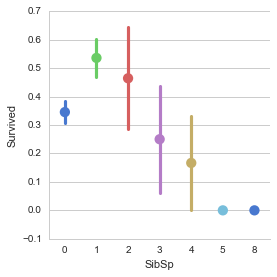

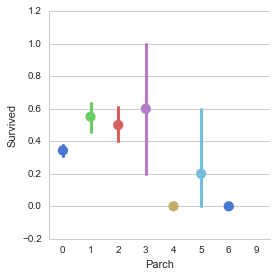

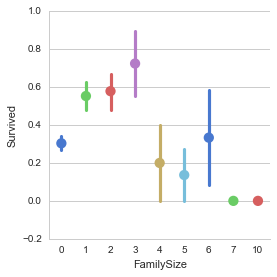

In [11]:
# FamilySize
df['FamilySize'] = df['SibSp'] + df['Parch']
if 'FamilySize' not in numerical_columns:
    numerical_columns.append('FamilySize')
g = sns.factorplot(x="SibSp", y="Survived", data=df, size=4, palette="muted")
g = sns.factorplot(x="Parch", y="Survived", data=df, size=4, palette="muted")
g = sns.factorplot(x="FamilySize", y="Survived", data=df, size=4, palette="muted")

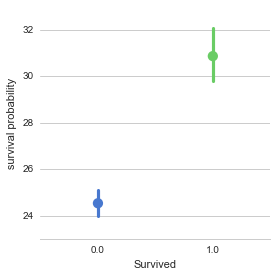

In [12]:
# Name Length?
df['NameLength'] = df["Name"].apply(lambda x: len(x))
if 'NameLength' not in numerical_columns:
    numerical_columns.append('NameLength')
g = sns.factorplot(y="NameLength", x="Survived", data=df, size=4, palette="muted")
g.despine(left=True)
g.set_ylabels("survival probability")

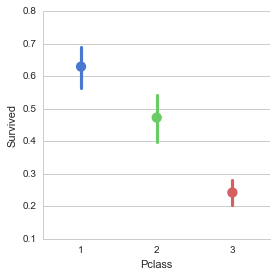

In [13]:
# Pclass
g = sns.factorplot(x="Pclass", y="Survived", data=df, size=4, palette="muted")

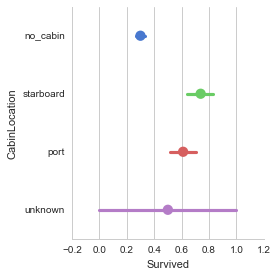

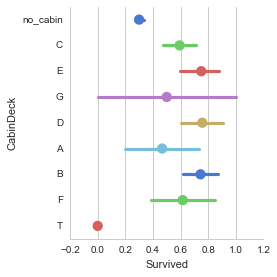

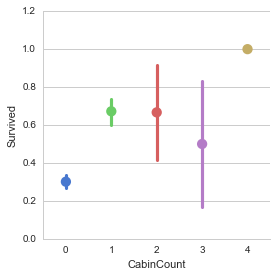

In [14]:
# cabin
# https://www.kaggle.com/c/titanic/prospector#1326
def get_cabin_location(cabin):
    if cabin == ' ':
        return 'no_cabin'
    # The cabin info consists of a letter (corresponding to a deck) 
    # and a cabin number, which is odd for cabins on the starboard side and even for the port.
    cabin_search_result = re.search('\d+', cabin)
    if cabin_search_result:
        type_code = np.int64(cabin_search_result.group(0))
        if type_code % 2 == 0:
            return 'port'
        else:
            return 'starboard'
    return 'unknown'

def get_cabin_deck(cabin):
    if cabin == ' ':
        return 'no_cabin'
    # The cabin info consists of a letter (corresponding to a deck) 
    # and a cabin number, which is odd for cabins on the starboard side and even for the port.
    cabin_search_result = re.search('[A-z]+', cabin)
    if cabin_search_result:
        return cabin_search_result.group(0)
    return 'unknown'

def get_cabin_count(cabin):
    if cabin == ' ':
        return 0
    cabin_search_result = re.findall('([A-z]\d+)', cabin)
    if cabin_search_result:
        return len(cabin_search_result)
    return 0

df['CabinLocation'] = df['Cabin'].fillna(' ').apply(get_cabin_location)
df['CabinDeck'] = df['Cabin'].fillna(' ').apply(get_cabin_deck)
df['CabinCount'] = df['Cabin'].fillna(' ').apply(get_cabin_count)

if 'CabinLocation' not in categorical_columns:
    categorical_columns.append('CabinLocation')
if 'CabinDeck' not in categorical_columns:
    categorical_columns.append('CabinDeck')
if 'CabinCount' not in numerical_columns:
    numerical_columns.append('CabinCount')

g = sns.factorplot(x="Survived", y="CabinLocation", data=df, size=4, palette="muted")
g = sns.factorplot(x="Survived", y="CabinDeck", data=df, size=4, palette="muted")
g = sns.factorplot(x="CabinCount", y="Survived", data=df, size=4, palette="muted")

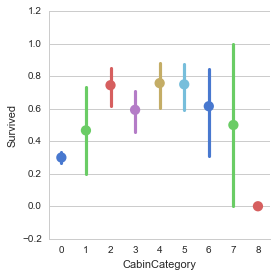

In [160]:
df['CabinCategory'] = pd.Categorical.from_array(df.Cabin.fillna('0').apply(lambda x:x[0])).codes
g = sns.factorplot(y="Survived", x="CabinCategory", data=df, size=4, palette="muted")
if 'CabinCategory' not in categorical_columns:
    categorical_columns.append('CabinCategory')

count    1309.000000
mean       33.295479
std        51.738879
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: Fare, dtype: float64
Axes(0.125,0.125;0.775x0.775)


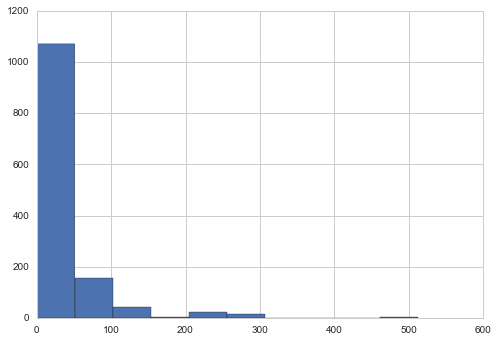

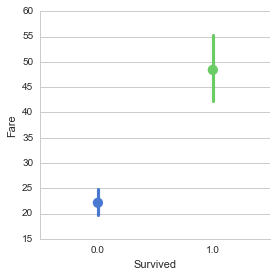

In [15]:
# Fare
df['Fare'] = df['Fare'].fillna(df['Fare'].mean())
print(df['Fare'].describe())
print(df['Fare'].hist())
g = sns.factorplot(x="Survived", y="Fare", data=df, size=4, palette="muted")

   Pclass     Fare  TicketMembers
0       3   7.2500              1
1       1  71.2833              2
2       3   7.9250              1
3       1  53.1000              2
4       3   8.0500              1
Axes(0.125,0.125;0.775x0.775)


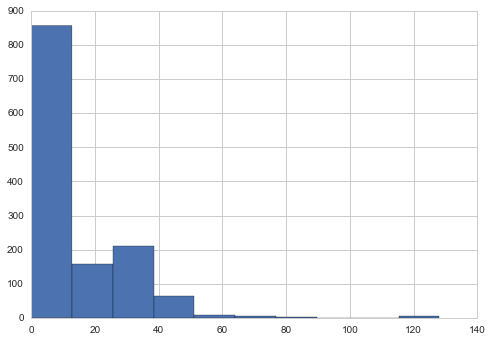

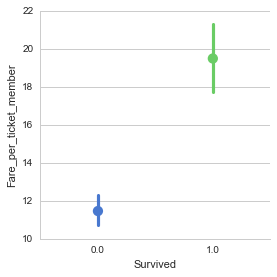

In [16]:
df['TicketMembers'] = df['TicketMembers'].fillna(0)
print(df.head()[['Pclass','Fare', 'TicketMembers']])
df['Fare_per_ticket_member'] = df['Fare'] / (df['TicketMembers'])
print(df['Fare_per_ticket_member'].hist())
g = sns.factorplot(x="Survived", y="Fare_per_ticket_member", data=df, size=4, palette="muted")

In [17]:
from math import log

class_fare = pd.DataFrame(columns=['count','mean','std','min','25%','50%','75%','max'])
class_fare.loc[1,:] = df[df['Pclass'] == 1]['Fare'].describe()
class_fare.loc[2,:] = df[df['Pclass'] == 2]['Fare'].describe()
class_fare.loc[3,:] = df[df['Pclass'] == 3]['Fare'].describe()

very_small_val = 0.01
df['Fare_standard_score_with_Pclass'] = df.apply(lambda row: (log(row['Fare'] + very_small_val) - log(class_fare.loc[row['Pclass'], 'mean'] + very_small_val)) / log(class_fare.loc[row['Pclass'], 'std'] + very_small_val), axis=1)
if 'Fare_standard_score_with_Pclass' not in numerical_columns:
    numerical_columns.append('Fare_standard_score_with_Pclass')

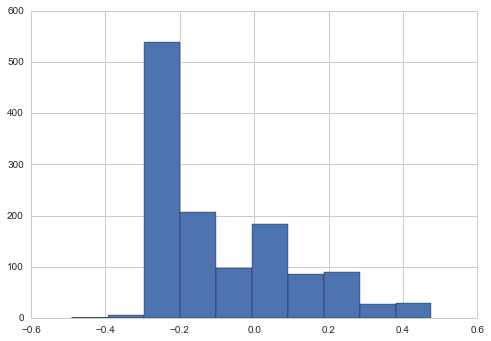

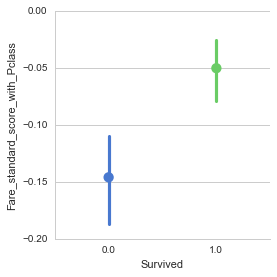

In [18]:
df[(df['Fare_standard_score_with_Pclass'] >= -0.5) & (df['Fare_standard_score_with_Pclass'] <= 0.5)]['Fare_standard_score_with_Pclass'].hist()
g = sns.factorplot(x="Survived", y="Fare_standard_score_with_Pclass", data=df, size=4, palette="muted")

In [19]:
from math import log

class_fare = pd.DataFrame(columns=['count','mean','std','min','25%','50%','75%','max'])
class_fare.loc[1,:] = df[df['Pclass'] == 1]['Fare_per_ticket_member'].describe()
class_fare.loc[2,:] = df[df['Pclass'] == 2]['Fare_per_ticket_member'].describe()
class_fare.loc[3,:] = df[df['Pclass'] == 3]['Fare_per_ticket_member'].describe()

very_small_val = 0.01
df['Fare_per_ticket_member_standard_score_with_Pclass'] = df.apply(lambda row: (log(row['Fare_per_ticket_member'] + very_small_val) - log(class_fare.loc[row['Pclass'], 'mean'] + very_small_val)) / log(class_fare.loc[row['Pclass'], 'std'] + very_small_val), axis=1)
if 'Fare_per_ticket_member_standard_score_with_Pclass' not in numerical_columns:
    numerical_columns.append('Fare_per_ticket_member_standard_score_with_Pclass')

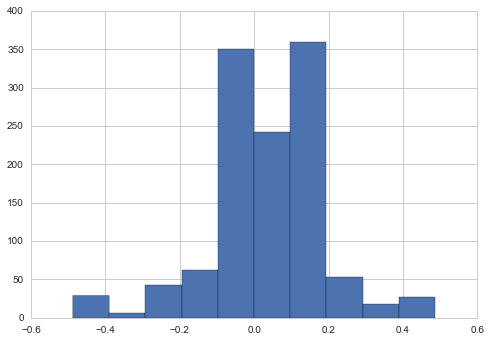

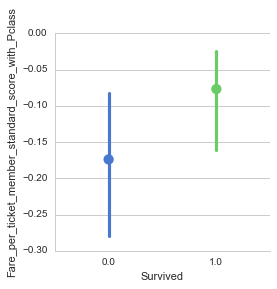

In [20]:
df[(df['Fare_per_ticket_member_standard_score_with_Pclass'] >= -0.5) & (df['Fare_per_ticket_member_standard_score_with_Pclass'] <= 0.5)]['Fare_per_ticket_member_standard_score_with_Pclass'].hist()
g = sns.factorplot(x="Survived", y="Fare_per_ticket_member_standard_score_with_Pclass", data=df, size=4, palette="muted")

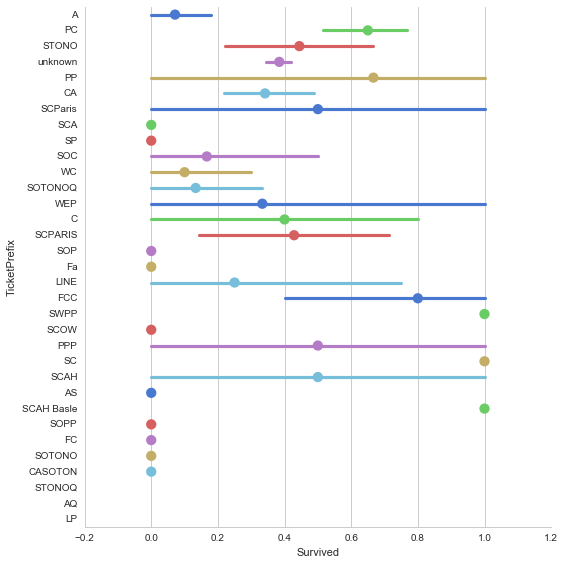

In [21]:
# https://www.kaggle.com/c/titanic/forums/t/11127/do-ticket-numbers-mean-anything
#print(df["Ticket"])
#print(df["Ticket"].value_counts())

def get_ticket_prefix(cabin):
    # The cabin info consists of a letter (corresponding to a deck) 
    # and a cabin number, which is odd for cabins on the starboard side and even for the port.
    cabin_search_result = re.search('[^\d]+', cabin)
    if cabin_search_result:
        return cabin_search_result.group(0).replace('/', '').replace('.', '').strip()
    return 'unknown'

df['TicketPrefix'] = df['Ticket'].apply(get_ticket_prefix)
g = sns.factorplot(y="TicketPrefix", x="Survived", data=df, size=8, palette="muted")

if 'TicketPrefix' not in categorical_columns:
    categorical_columns.append('TicketPrefix')

In [161]:
for col in categorical_columns:
    df = category_to_numeric(df, col)

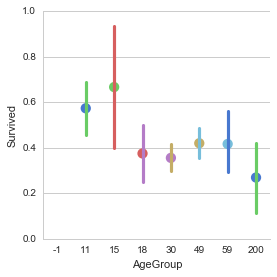

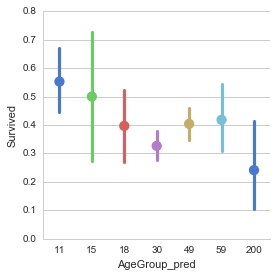

In [23]:
# age prediction
from sklearn.ensemble import ExtraTreesRegressor

age_prediction_features = ['Fare', 'Fare_standard_score_with_Pclass',
                           #'Fare_per_ticket_member', 'Fare_per_ticket_member_standard_score_with_Pclass',
                           'Parch', 'Pclass', 'SibSp', 'Sex_female', 'Sex_male', 'FamilySize',
                           'NameLength', 'TicketMembers', 'TicketId', 
                           'Embarked_S', 'Embarked_C', 'Embarked_Q', 'Embarked_unknown', 
                           'Name_title_Mr', 'Name_title_Mrs', 'Name_title_Miss', 'Name_title_Master', 
                           'Name_title_Don', 'Name_title_Rev', 'Name_title_Dr', 'Name_title_Mme', 
                           'Name_title_Major', 'Name_title_Lady', 'Name_title_Sir', 'Name_title_Mlle', 'Name_title_Col', 
                           'Name_title_Capt', 'Name_title_Countess', 'Name_title_Jonkheer', 
                           'CabinLocation_no_cabin', 'CabinLocation_starboard', 'CabinLocation_port', 'CabinDeck_no_cabin', 
                           'CabinDeck_C', 'CabinDeck_E', 'CabinDeck_G', 'CabinDeck_D', 'CabinDeck_A', 'CabinDeck_B', 'CabinDeck_F', 'CabinDeck_T'
                          ]
age_prediction_tree_regressor = ExtraTreesRegressor(n_estimators=200)
age_X_train = df[age_prediction_features][df['Age'].notnull()]
age_Y_train = df['Age'][df['Age'].notnull()]
age_prediction_tree_regressor.fit(age_X_train, np.ravel(age_Y_train))

# predict only isnull values
df['Age_pred'] = df['Age']
df.loc[df[df['Age'].isnull()].index, 'Age_pred'] = age_prediction_tree_regressor.predict(df[age_prediction_features][df['Age'].isnull()])

if 'Age_pred' not in numerical_columns:
    numerical_columns.append('Age_pred')

# add ageGroup
df["AgeGroup"] = pd.cut(df['Age'], bins=[-2000,0,11,15,18,30,49,59,200], labels=[-1, 11,15,18,30,49,59,200])
df["AgeGroup_pred"] = pd.cut(df['Age_pred'], bins=[-2000,11,15,18,30,49,59,200], labels=[11,15,18,30,49,59,200])

if 'AgeGroup' not in numerical_columns:
    numerical_columns.append('AgeGroup')
if 'AgeGroup_pred' not in numerical_columns:
    numerical_columns.append('AgeGroup_pred')
    
g = sns.factorplot(y="Survived", x="AgeGroup", data=df, size=4, palette="muted")
g = sns.factorplot(y="Survived", x="AgeGroup_pred", data=df, size=4, palette="muted")

In [24]:
# Frugal_First_Class_Single_Man
# midle age first class single man with large discounted and unknown prefixed ticket and without cabin.
print("died", df[(df['Survived'] == 0) & (df['Sex'] == 'male') 
         & (df['Pclass'] == 1) 
         & (df['Age_pred'] <= 45) 
         & (df['Fare'] > 0)
         & (df['Fare_standard_score_with_Pclass'] < -0.25)
         & (df['TicketPrefix_unknown'] == 1)
         & (df['TicketMembers_Simple'] == 0)
         & (df['CabinCount'] == 0)
        ])
print("survived", df[(df['Survived'] == 1) & (df['Sex'] == 'male') 
         & (df['Pclass'] == 1) 
         & (df['Age_pred'] <= 45) 
         & (df['Fare'] > 0)
         & (df['Fare_standard_score_with_Pclass'] < -0.25)
         & (df['TicketPrefix_unknown'] == 1)
         & (df['TicketMembers_Simple'] == 0)
         & (df['CabinCount'] == 0)
        ])

('died', Empty DataFrame
Columns: [Age, Cabin, Embarked, Fare, Name, Parch, PassengerId, Pclass, Sex, SibSp, Survived, Ticket, SexAdult, TicketMembers, Ticket_perishing_women, TicketGroup_include_perishing_women, Ticket_surviving_men, TicketGroup_include_surviving_men, TicketId, TicketMembers_Simple, surname, SurnameMembers, Surname_perishing_women, SurnameGroup_include_perishing_women, Surname_surviving_men, SurnameGroup_include_surviving_men, SurnameId, SurnameMembers_Simple, Name_title, FamilySize, NameLength, CabinLocation, CabinDeck, CabinCount, Fare_per_ticket_member, Fare_standard_score_with_Pclass, Fare_per_ticket_member_standard_score_with_Pclass, TicketPrefix, Sex_female, Sex_male, Embarked_C, Embarked_Q, Embarked_S, Embarked_unknown, SexAdult_child, SexAdult_female_adult, SexAdult_male_adult, Name_title_Capt, Name_title_Col, Name_title_Countess, Name_title_Don, Name_title_Dona, Name_title_Dr, Name_title_Jonkheer, Name_title_Lady, Name_title_Major, Name_title_Master, Name_tit

In [228]:
df['Frugal_First_Class_Single_Man'] = 0

df.loc[df[(df['Sex'] == 'male') 
         & (df['Fare'] > 20)
         & (df['Fare'] < 27)
         & (df['Fare_standard_score_with_Pclass'] < -0.25)
         & (df['Age'] >= 30)
         & (df['Age'] < 45)
         & (df['Pclass'] == 1)]['Frugal_First_Class_Single_Man'].index, 'Frugal_First_Class_Single_Man'] = 1
print(df[(df['Sex'] == 'male') 
         & (df['Fare'] > 20)
         & (df['Fare'] < 27)
         & (df['Fare_standard_score_with_Pclass'] < -0.25)
         & (df['Age'] >= 30)
         & (df['Age'] < 45)
         & (df['Pclass'] == 1)]['Frugal_First_Class_Single_Man'])
if 'Frugal_First_Class_Single_Man' not in numerical_columns:
    numerical_columns.append('Frugal_First_Class_Single_Man')

447     1
512     1
572     1
604     1
701     1
707     1
1035    1
1049    1
1214    1
1226    1
Name: Frugal_First_Class_Single_Man, dtype: int64


In [341]:
display(df[(df['Sex'] == 'female') & 
   (df['Fare_standard_score_with_Pclass'] <= -0.18) & 
   (df['Age_pred'] > 30) & 
   (df['Pclass'] == 3) & 
   (df['Name_title_Miss'] == 1.0)
  ])

# poor old miss
df['Poor_Old_Miss_Third_Class'] = 0
df.loc[df[(df['Sex'] == 'female') & 
   (df['Fare_standard_score_with_Pclass'] <= -0.18) & 
   (df['Age'] > 30) & 
   (df['Pclass'] == 3) & 
   (df['Name_title_Miss'] == 1.0)].index, 'Poor_Old_Miss_Third_Class'] = 1
       
if 'Poor_Old_Miss_Third_Class' not in numerical_columns:
    numerical_columns.append('Poor_Old_Miss_Third_Class')

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,SexAdult,TicketMembers,Ticket_perishing_women,TicketGroup_include_perishing_women,Ticket_surviving_men,TicketGroup_include_surviving_men,TicketId,TicketMembers_Simple,surname,SurnameMembers,Surname_perishing_women,SurnameGroup_include_perishing_women,Surname_surviving_men,SurnameGroup_include_surviving_men,SurnameId,SurnameMembers_Simple,Name_title,FamilySize,NameLength,CabinLocation,CabinDeck,CabinCount,Fare_per_ticket_member,Fare_standard_score_with_Pclass,Fare_per_ticket_member_standard_score_with_Pclass,TicketPrefix,Age_pred,AgeGroup,AgeGroup_pred,Frugal_First_Class_Single_Man,Poor_Old_Miss,Poor_Shouthampton_Old_Miss,TitleCategory,Name_titleCategory,CabinCategory,Sex_female,Sex_male,Embarked_C,...,TicketPrefix_CA,TicketPrefix_CASOTON,TicketPrefix_FC,TicketPrefix_FCC,TicketPrefix_Fa,TicketPrefix_LINE,TicketPrefix_LP,TicketPrefix_PC,TicketPrefix_PP,TicketPrefix_PPP,TicketPrefix_SC,TicketPrefix_SCA,TicketPrefix_SCAH,TicketPrefix_SCAH Basle,TicketPrefix_SCOW,TicketPrefix_SCPARIS,TicketPrefix_SCParis,TicketPrefix_SOC,TicketPrefix_SOP,TicketPrefix_SOPP,TicketPrefix_SOTONO,TicketPrefix_SOTONOQ,TicketPrefix_SP,TicketPrefix_STONO,TicketPrefix_STONOQ,TicketPrefix_SWPP,TicketPrefix_WC,TicketPrefix_WEP,TicketPrefix_unknown,Name_titleCategory_1,Name_titleCategory_2,Name_titleCategory_3,Name_titleCategory_4,Name_titleCategory_5,Name_titleCategory_6,Name_titleCategory_7,Name_titleCategory_9,Name_titleCategory_10,CabinCategory_0,CabinCategory_1,CabinCategory_2,CabinCategory_3,CabinCategory_4,CabinCategory_5,CabinCategory_6,CabinCategory_7,CabinCategory_8,Poor_Old_Miss_Third_Class,Poor_Old_Miss_Second_Class,Poor_Old_Miss_First_Class
32,NaN,NaN,Q,7.7500,"Glynn, Miss. Mary Agatha",0,33,3,female,0,1.0,335677,female_adult,1,0.0,0,0.0,0,-1,0,glynn,1,0.0,0,0.0,0,-1,0,Miss,0,24,no_cabin,no_cabin,0,7.7500,-0.221699,0.088560,unknown,35.00,NaN,49,0,1,0,2,2,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
264,NaN,NaN,Q,7.7500,"Henry, Miss. Delia",0,265,3,female,0,0.0,382649,female_adult,1,0.0,0,0.0,0,-1,0,henry,1,0.0,0,0.0,0,-1,0,Miss,0,18,no_cabin,no_cabin,0,7.7500,-0.221699,0.088560,unknown,30.50,NaN,49,0,1,0,2,2,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
276,45.0,NaN,S,7.7500,"Lindblom, Miss. Augusta Charlotta",0,277,3,female,0,0.0,347073,female_adult,1,0.0,0,0.0,0,-1,0,lindblom,1,0.0,0,0.0,0,-1,0,Miss,0,33,no_cabin,no_cabin,0,7.7500,-0.221699,0.088560,unknown,45.00,49.0,49,0,1,1,2,2,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
396,31.0,NaN,S,7.8542,"Olsson, Miss. Elina",0,397,3,female,0,0.0,350407,female_adult,1,0.0,0,0.0,0,-1,0,olsson,3,0.0,0,0.0,0,600,1,Miss,0,19,no_cabin,no_cabin,0,7.8542,-0.216242,0.111822,unknown,31.00,49.0,49,0,1,1,2,2,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
573,NaN,NaN,Q,7.7500,"Kelly, Miss. Mary",0,574,3,female,0,1.0,14312,female_adult,1,0.0,0,0.0,0,-1,0,kelly,5,0.0,0,0.0,0,406,2,Miss,0,17,no_cabin,no_cabin,0,7.7500,-0.221699,0.088560,unknown,30.33,NaN,49,0,1,0,2,2,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
727,NaN,NaN,Q,7.7375,"Mannion, Miss. Margareth",0,728,3,female,0,1.0,36866,female_adult,1,0.0,0,0.0,0,-1,0,mannio

In [338]:
display(df[(df['Sex'] == 'female') & 
   (df['Fare_standard_score_with_Pclass'] <= -0.18) & 
   (df['Age_pred'] >= 38) & 
   (df['Pclass'] == 2) & 
   (df['Name_title_Miss'] == 1.0) &
   (df['TicketPrefix_unknown'] == 1.0) &
   (df['SurnameMembers_Simple'] == 0)
  ])

# poor old miss
df['Poor_Old_Miss_Second_Class'] = 0
df.loc[df[
        (df['Sex'] == 'female') & 
        (df['Fare_standard_score_with_Pclass'] <= -0.18) & 
        (df['Age_pred'] >= 38) & 
        (df['Pclass'] == 2) & 
        (df['Name_title_Miss'] == 1.0) &
        (df['TicketPrefix_unknown'] == 1.0) &
        (df['SurnameMembers_Simple'] == 0)
         ].index, 'Poor_Old_Miss_Second_Class'] = 1
       
if 'Poor_Old_Miss_Second_Class' not in numerical_columns:
    numerical_columns.append('Poor_Old_Miss_Second_Class')

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,SexAdult,TicketMembers,Ticket_perishing_women,TicketGroup_include_perishing_women,Ticket_surviving_men,TicketGroup_include_surviving_men,TicketId,TicketMembers_Simple,surname,SurnameMembers,Surname_perishing_women,SurnameGroup_include_perishing_women,Surname_surviving_men,SurnameGroup_include_surviving_men,SurnameId,SurnameMembers_Simple,Name_title,FamilySize,NameLength,CabinLocation,CabinDeck,CabinCount,Fare_per_ticket_member,Fare_standard_score_with_Pclass,Fare_per_ticket_member_standard_score_with_Pclass,TicketPrefix,Age_pred,AgeGroup,AgeGroup_pred,Frugal_First_Class_Single_Man,Poor_Old_Miss,Poor_Shouthampton_Old_Miss,TitleCategory,Name_titleCategory,CabinCategory,Sex_female,Sex_male,Embarked_C,...,TicketPrefix_CA,TicketPrefix_CASOTON,TicketPrefix_FC,TicketPrefix_FCC,TicketPrefix_Fa,TicketPrefix_LINE,TicketPrefix_LP,TicketPrefix_PC,TicketPrefix_PP,TicketPrefix_PPP,TicketPrefix_SC,TicketPrefix_SCA,TicketPrefix_SCAH,TicketPrefix_SCAH Basle,TicketPrefix_SCOW,TicketPrefix_SCPARIS,TicketPrefix_SCParis,TicketPrefix_SOC,TicketPrefix_SOP,TicketPrefix_SOPP,TicketPrefix_SOTONO,TicketPrefix_SOTONOQ,TicketPrefix_SP,TicketPrefix_STONO,TicketPrefix_STONOQ,TicketPrefix_SWPP,TicketPrefix_WC,TicketPrefix_WEP,TicketPrefix_unknown,Name_titleCategory_1,Name_titleCategory_2,Name_titleCategory_3,Name_titleCategory_4,Name_titleCategory_5,Name_titleCategory_6,Name_titleCategory_7,Name_titleCategory_9,Name_titleCategory_10,CabinCategory_0,CabinCategory_1,CabinCategory_2,CabinCategory_3,CabinCategory_4,CabinCategory_5,CabinCategory_6,CabinCategory_7,CabinCategory_8,Poor_Old_Miss_Third_Class,Poor_Old_Miss_Second_Class,Poor_Old_Miss_First_Class
357,38.0,NaN,S,13.0,"Funk, Miss. Annie Clemmer",0,358,2,female,0,0.0,237671,female_adult,1,0.0,0,0.0,0,-1,0,funk,1,0.0,0,0.0,0,-1,0,Miss,0,25,no_cabin,no_cabin,0,13.0,-0.186791,0.134032,unknown,38.0,49,49,0,0,0,2,2,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0


In [337]:
display(df[
    (df['Sex'] == 'female') & 
    (df['Fare_standard_score_with_Pclass'] <= -0.18) & 
    (df['Age_pred'] >= 35) & 
    (df['Pclass'] == 1) & 
    (df['Name_title_Miss'] == 1.0) &
    (df['SurnameMembers_Simple'] == 0)
  ])

# poor old miss
df['Poor_Old_Miss_First_Class'] = 0
df.loc[df[
            (df['Sex'] == 'female') & 
            (df['Fare_standard_score_with_Pclass'] <= -0.18) & 
            (df['Age_pred'] >= 35) & 
            (df['Pclass'] == 1) & 
            (df['Name_title_Miss'] == 1.0) &
            (df['SurnameMembers_Simple'] == 0)
         ].index, 'Poor_Old_Miss_First_Class'] = 1
       
if 'Poor_Old_Miss_First_Class' not in numerical_columns:
    numerical_columns.append('Poor_Old_Miss_First_Class')

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,SexAdult,TicketMembers,Ticket_perishing_women,TicketGroup_include_perishing_women,Ticket_surviving_men,TicketGroup_include_surviving_men,TicketId,TicketMembers_Simple,surname,SurnameMembers,Surname_perishing_women,SurnameGroup_include_perishing_women,Surname_surviving_men,SurnameGroup_include_surviving_men,SurnameId,SurnameMembers_Simple,Name_title,FamilySize,NameLength,CabinLocation,CabinDeck,CabinCount,Fare_per_ticket_member,Fare_standard_score_with_Pclass,Fare_per_ticket_member_standard_score_with_Pclass,TicketPrefix,Age_pred,AgeGroup,AgeGroup_pred,Frugal_First_Class_Single_Man,Poor_Old_Miss,Poor_Shouthampton_Old_Miss,TitleCategory,Name_titleCategory,CabinCategory,Sex_female,Sex_male,Embarked_C,...,TicketPrefix_CA,TicketPrefix_CASOTON,TicketPrefix_FC,TicketPrefix_FCC,TicketPrefix_Fa,TicketPrefix_LINE,TicketPrefix_LP,TicketPrefix_PC,TicketPrefix_PP,TicketPrefix_PPP,TicketPrefix_SC,TicketPrefix_SCA,TicketPrefix_SCAH,TicketPrefix_SCAH Basle,TicketPrefix_SCOW,TicketPrefix_SCPARIS,TicketPrefix_SCParis,TicketPrefix_SOC,TicketPrefix_SOP,TicketPrefix_SOPP,TicketPrefix_SOTONO,TicketPrefix_SOTONOQ,TicketPrefix_SP,TicketPrefix_STONO,TicketPrefix_STONOQ,TicketPrefix_SWPP,TicketPrefix_WC,TicketPrefix_WEP,TicketPrefix_unknown,Name_titleCategory_1,Name_titleCategory_2,Name_titleCategory_3,Name_titleCategory_4,Name_titleCategory_5,Name_titleCategory_6,Name_titleCategory_7,Name_titleCategory_9,Name_titleCategory_10,CabinCategory_0,CabinCategory_1,CabinCategory_2,CabinCategory_3,CabinCategory_4,CabinCategory_5,CabinCategory_6,CabinCategory_7,CabinCategory_8,Poor_Old_Miss_Third_Class,Poor_Old_Miss_Second_Class,Poor_Old_Miss_First_Class
177,50.0,C49,C,28.7125,"Isham, Miss. Ann Elizabeth",0,178,1,female,0,0.0,PC 17595,female_adult,1,0.0,0,0.0,0,-1,0,isham,1,0.0,0,0.0,0,-1,0,Miss,0,26,starboard,C,1,28.7125,-0.253930,-0.060862,PC,50.0,59,59,0,0,0,2,2,3,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,1
1003,36.0,A29,C,31.6792,"Evans, Miss. Edith Corse",0,1004,1,female,0,NaN,PC 17531,female_adult,1,0.0,0,0.0,0,-1,0,evans,1,0.0,0,0.0,0,-1,0,Miss,0,24,starboard,A,1,31.6792,-0.231528,-0.024897,PC,36.0,49,49,0,0,0,2,2,1,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1


In [26]:
df[(df['Sex'] == 'female') & (df['Fare'] <= 10) & (df['Age'] > 28) & (df['Name_title_Miss'] == 1.0)]

# poor old miss
df['Poor_Old_Miss'] = 0
df.loc[df[(df['Sex'] == 'female') 
         & (df['Fare'] <= 10) 
         & (df['Age_pred'] > 28) 
         & (df['Name_title_Miss'] == 1.0)].index, 'Poor_Old_Miss'] = 1
       
if 'Poor_Old_Miss' not in numerical_columns:
    numerical_columns.append('Poor_Old_Miss')

In [27]:
df[(df['Sex'] == 'female') & (df['Fare'] <= 10) & (df['Age'] > 26) & (df['Embarked'] == 'S') & (df['Name_title_Miss'] == 1.0)]

# poor Shouthampton old miss
df['Poor_Shouthampton_Old_Miss'] = 0
df.loc[df[(df['Sex'] == 'female') 
         & (df['Fare'] <= 10) 
         & (df['Age_pred'] > 26) 
         & (df['Embarked'] == 'S') 
         & (df['Name_title_Miss'] == 1.0)].index, 'Poor_Shouthampton_Old_Miss'] = 1
       
if 'Poor_Shouthampton_Old_Miss' not in numerical_columns:
    numerical_columns.append('Poor_Shouthampton_Old_Miss')

In [318]:
# feature selection
from sklearn.feature_selection import SelectKBest, f_classif

df_copied = df.copy()
df_copied['Name_titleCategory'] = df_copied['Name_titleCategory'].fillna(' ')
df_copied['Cabin'] = df_copied['Cabin'].fillna(' ')
df_copied['Age'] = df_copied['Age'].fillna(-300)
df_copied['AgeGroup'] = df_copied['AgeGroup'].fillna(-1.0)

train = df_copied[0:891].copy()
target = train["Survived"].values

selector = SelectKBest(f_classif, k=len(numerical_columns))
selector.fit(train[numerical_columns], target)
scores = -np.log10(selector.pvalues_)
indices = np.argsort(scores)[::-1]
print("Features importance :")
for f in range(len(scores)):
    print("%0.2f %s" % (scores[indices[f]],numerical_columns[indices[f]]))

Features importance :
nan TicketPrefix_STONOQ
nan Name_title_Dona
nan TicketPrefix_AQ
nan TicketPrefix_LP
70.61 Name_title_Mr
70.61 Name_titleCategory_1
68.85 Sex_female
68.85 Sex_male
64.90 SexAdult_male_adult
53.23 SexAdult_female_adult
25.12 Name_titleCategory_3
24.68 Name_title_Mrs
24.60 Pclass
24.17 Name_titleCategory_2
23.69 NameLength
23.35 Name_title_Miss
21.51 CabinDeck_no_cabin
21.51 CabinLocation_no_cabin
21.51 CabinCategory_0
17.23 CabinCount
17.00 TicketGroup_include_surviving_men
16.30 Ticket_surviving_men
14.21 Fare
13.54 TicketGroup_include_perishing_women
13.22 CabinLocation_starboard
13.04 SurnameGroup_include_surviving_men
12.71 Surname_surviving_men
10.83 Ticket_perishing_women
10.36 SurnameGroup_include_perishing_women
9.04 Surname_perishing_women
6.84 CabinDeck_B
6.84 CabinCategory_2
6.73 CabinLocation_port
6.36 Embarked_C
5.52 Embarked_S
5.21 CabinCategory_4
5.21 CabinDeck_D
4.98 TicketPrefix_PC
4.88 CabinDeck_E
4.88 CabinCategory_5
3.59 SexAdult_child
3.38 Fare_

In [29]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation

random_forest = RandomForestClassifier(n_estimators=3000, min_samples_split=4, class_weight={0:0.745, 1:0.255})
kfold = cross_validation.KFold(train.shape[0], n_folds=3, random_state=42)

scores = cross_validation.cross_val_score(random_forest, train[numerical_columns], target, cv=kfold)
print("Accuracy: %0.3f (+/- %0.2f) [%s]" % (scores.mean() * 100, scores.std() * 100, 'Random Forest Cross Validation'))

random_forest.fit(train[numerical_columns], target)
score = random_forest.score(train[numerical_columns], target)
print("Accuracy: %0.3f             [%s]" % (score * 100, 'Random Forest full test'))

importances = random_forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(len(numerical_columns)):
    print("%d. feature %d (%f) %s" % (f + 1, indices[f] + 1, importances[indices[f]] * 100, numerical_columns[indices[f]]))



Accuracy: 90.797 (+/- 1.24) [Random Forest Cross Validation]
Accuracy: 96.970             [Random Forest full test]
1. feature 23 (5.452351) Sex_male
2. feature 24 (5.106521) Sex_female
3. feature 19 (4.770819) NameLength
4. feature 32 (4.766405) Name_title_Mr
5. feature 29 (4.717052) SexAdult_male_adult
6. feature 5 (4.695923) Fare
7. feature 95 (4.451204) Age_pred
8. feature 21 (4.165854) Fare_standard_score_with_Pclass
9. feature 6 (4.049780) Ticket_perishing_women
10. feature 30 (3.883677) SexAdult_female_adult
11. feature 7 (3.769792) TicketGroup_include_perishing_women
12. feature 12 (3.642624) Surname_perishing_women
13. feature 13 (3.592287) SurnameGroup_include_perishing_women
14. feature 22 (3.325737) Fare_per_ticket_member_standard_score_with_Pclass
15. feature 2 (3.055111) Age
16. feature 1 (2.844268) Pclass
17. feature 8 (2.493148) Ticket_surviving_men
18. feature 9 (2.448331) TicketGroup_include_surviving_men
19. feature 11 (2.085820) TicketMembers
20. feature 18 (1.69960

In [30]:
import matplotlib.pyplot as plt

from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

ensemble_clfs = [
    ("RandomForestClassifier",
        RandomForestClassifier(
                               n_estimators=3000,
                               n_jobs=8,
                               class_weight={0:0.745, 1:0.255},
                               min_samples_split=4,
                               random_state=42)),
]

kfold = cross_validation.KFold(train.shape[0], n_folds=3, random_state=42)

In [31]:
# error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)
# for label, clf in ensemble_clfs:
#     print("Classifier : %s" % label)
#     for i in range(2, 10):
#         clf.set_params(min_samples_split=i)
#         clf.fit(train[numerical_columns], target)
#         scores = cross_validation.cross_val_score(clf, train[numerical_columns], target, cv=kfold)
#         error_rate[label].append((i, scores.mean() * 100))
#         print("%d estimator" % i)
        
# for label, clf_err in error_rate.items():
#     xs, ys = zip(*clf_err)
#     plt.plot(xs, ys, label=label)
    
# plt.xlim(2, 10)
# plt.xlabel("min_samples_split")
# plt.ylabel("score")
# plt.legend(loc="upper right")
# plt.show()

Classifier : RandomForestClassifier
2 estimator


Exception in thread Thread-104:
Traceback (most recent call last):
  File "c:\develop\python27\lib\threading.py", line 801, in __bootstrap_inner
    self.run()
  File "c:\develop\python27\lib\threading.py", line 754, in run
    self.__target(*self.__args, **self.__kwargs)
  File "c:\develop\python27\lib\multiprocessing\pool.py", line 405, in _handle_results
    cache[job]._set(i, obj)
  File "c:\develop\python27\lib\multiprocessing\pool.py", line 572, in _set
    self._callback(self._value)
  File "c:\develop\python27\lib\site-packages\sklearn\externals\joblib\parallel.py", line 224, in __call__
    self.parallel.dispatch_next()
  File "c:\develop\python27\lib\site-packages\sklearn\externals\joblib\parallel.py", line 592, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "c:\develop\python27\lib\site-packages\sklearn\externals\joblib\parallel.py", line 658, in dispatch_one_batch
    self._dispatch(tasks)
  File "c:\develop\python27\lib\site-packages\s

KeyboardInterrupt: 

In [32]:
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)
for label, clf in ensemble_clfs:
    print("Classifier : %s" % label)
    for i in range(1, 100, 10):
        clf.set_params(max_depth=i)
        clf.fit(train[numerical_columns], target)
        scores = cross_validation.cross_val_score(clf, train[numerical_columns], target, cv=kfold)
#         error_rate[label].append((i, scores.mean() * 100))
        print("max_depth : %d" % i)
        
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)
    
plt.xlim(0, 100)
plt.xlabel("max_depth")
plt.ylabel("score")
plt.legend(loc="upper right")
plt.show()

Classifier : RandomForestClassifier
max_depth : 1


KeyboardInterrupt: 

In [319]:
features = [
            'Sex_female','Sex_male',
    
            'Age_pred',
    
            'SexAdult_male_adult','SexAdult_female_adult', 'SexAdult_child',
    
#             'Name_titleCategory',
            'Name_titleCategory_1',
            'Name_titleCategory_2',
            'Name_titleCategory_3',
            'Name_titleCategory_4',
            'Name_titleCategory_5',
            'Name_titleCategory_6',
            'Name_titleCategory_7',
            'Name_titleCategory_9',
            'Name_titleCategory_10',
#             'Name_title_Mr', 'Name_title_Mrs', 'Name_title_Miss', 'Name_title_Master', 
#             'Name_title_Don', 'Name_title_Rev', 'Name_title_Dr', 'Name_title_Mme', 
#             'Name_title_Major', 'Name_title_Lady', 'Name_title_Sir', 'Name_title_Mlle', 'Name_title_Col', 
#             'Name_title_Capt', 'Name_title_Countess', 'Name_title_Jonkheer', 

            'Pclass', 
            
            'TicketId',
    
            'NameLength',

            'CabinLocation_no_cabin', 'CabinLocation_starboard', 'CabinLocation_port', 'CabinDeck_no_cabin', 
#             'CabinCategory',
            'CabinCategory_0',
            'CabinCategory_1',
            'CabinCategory_2',
            'CabinCategory_3',
            'CabinCategory_4',
            'CabinCategory_5',
            'CabinCategory_6',
            'CabinCategory_7',
            'CabinCategory_8',
#             'CabinDeck_C', 'CabinDeck_E', 'CabinDeck_G', 'CabinDeck_D', 'CabinDeck_A', 'CabinDeck_B', 'CabinDeck_F', 'CabinDeck_T',

            'SibSp','Parch',
    
            'Fare',
#             'Fare_per_ticket_member',
            'Fare_standard_score_with_Pclass',
#             'Fare_per_ticket_member_standard_score_with_Pclass',
    
            'Embarked_S','Embarked_Q','Embarked_C','Embarked_unknown',
    
            'SurnameMembers_Simple','SurnameGroup_include_perishing_women','SurnameGroup_include_surviving_men',
    
            'TicketMembers_Simple', 'TicketGroup_include_perishing_women','TicketGroup_include_surviving_men',
    
            'FamilySize', 

            'Frugal_First_Class_Single_Man',
#             'Poor_Old_Miss',
#             'Poor_Shouthampton_Old_Miss',
#             'Poor_Old_Miss_Third_Class',
#             'Poor_Old_Miss_Second_Class',
#             'Poor_Old_Miss_First_Class',
    
#             'TicketPrefix_unknown', 
#             'TicketPrefix_SCA','TicketPrefix_SP','TicketPrefix_SOP','TicketPrefix_Fa','TicketPrefix_SCOW','TicketPrefix_AS','TicketPrefix_SOPP',
#             'TicketPrefix_FC','TicketPrefix_SOTONO','TicketPrefix_CASOTON','TicketPrefix_SWPP','TicketPrefix_SC','TicketPrefix_SCAH Basle',
    
#             'CabinCount',
           ]


In [320]:
# analyze failed.
X_train, X_test, y_train, y_test = cross_validation.train_test_split(train, target, test_size=0.2, random_state=42)
random_forest = RandomForestClassifier(n_estimators=3000, min_samples_split=4, class_weight={0:0.745, 1:0.255})
kfold = cross_validation.KFold(X_train.shape[0], n_folds=3, random_state=42)

scores = cross_validation.cross_val_score(random_forest, X_train[features], y_train, cv=kfold)
print("Accuracy: %0.3f (+/- %0.2f) [%s]" % (scores.mean() * 100, scores.std() * 100, 'Random Forest Cross Validation'))

random_forest.fit(X_train[features], y_train)
score = random_forest.score(X_test[features], y_test)
print("Accuracy: %0.3f             [%s]" % (score * 100, 'Random Forest full test'))
pred_test = random_forest.predict(X_test[features])

importances = random_forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(len(features)):
    print("%d. feature %d (%f) %s" % (f + 1, indices[f] + 1, importances[indices[f]] * 100, features[indices[f]]))

Accuracy: 88.907 (+/- 1.19) [Random Forest Cross Validation]
Accuracy: 92.179             [Random Forest full test]
1. feature 3 (7.357344) Age_pred
2. feature 34 (7.022992) Fare
3. feature 18 (6.871062) NameLength
4. feature 41 (6.690243) SurnameGroup_include_perishing_women
5. feature 35 (6.399540) Fare_standard_score_with_Pclass
6. feature 44 (6.364396) TicketGroup_include_perishing_women
7. feature 2 (5.762218) Sex_male
8. feature 1 (5.324205) Sex_female
9. feature 7 (5.323238) Name_titleCategory_1
10. feature 16 (4.998550) Pclass
11. feature 4 (4.540432) SexAdult_male_adult
12. feature 45 (4.036175) TicketGroup_include_surviving_men
13. feature 5 (3.762767) SexAdult_female_adult
14. feature 42 (2.439697) SurnameGroup_include_surviving_men
15. feature 43 (2.296549) TicketMembers_Simple
16. feature 9 (2.285163) Name_titleCategory_3
17. feature 46 (2.219730) FamilySize
18. feature 40 (1.802121) SurnameMembers_Simple
19. feature 8 (1.277663) Name_titleCategory_2
20. feature 17 (1.2139

In [321]:
pd.set_option("display.max_columns",101)
X_test_reseted = X_test.reset_index()
X_test_reseted['Survived_'] = y_test
X_test_reseted['Prediction'] = pred_test
X_test_reseted['pred_result'] = pred_test == y_test

In [322]:
display(X_test_reseted[(X_test_reseted['Survived'] == 1.0) & (X_test_reseted['pred_result'] == False)])

,index,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,SexAdult,TicketMembers,Ticket_perishing_women,TicketGroup_include_perishing_women,Ticket_surviving_men,TicketGroup_include_surviving_men,TicketId,TicketMembers_Simple,surname,SurnameMembers,Surname_perishing_women,SurnameGroup_include_perishing_women,Surname_surviving_men,SurnameGroup_include_surviving_men,SurnameId,SurnameMembers_Simple,Name_title,FamilySize,NameLength,CabinLocation,CabinDeck,CabinCount,Fare_per_ticket_member,Fare_standard_score_with_Pclass,Fare_per_ticket_member_standard_score_with_Pclass,TicketPrefix,Age_pred,AgeGroup,AgeGroup_pred,Frugal_First_Class_Single_Man,Poor_Old_Miss,Poor_Shouthampton_Old_Miss,TitleCategory,Name_titleCategory,CabinCategory,Sex_female,Sex_male,...,TicketPrefix_FCC,TicketPrefix_Fa,TicketPrefix_LINE,TicketPrefix_LP,TicketPrefix_PC,TicketPrefix_PP,TicketPrefix_PPP,TicketPrefix_SC,TicketPrefix_SCA,TicketPrefix_SCAH,TicketPrefix_SCAH Basle,TicketPrefix_SCOW,TicketPrefix_SCPARIS,TicketPrefix_SCParis,TicketPrefix_SOC,TicketPrefix_SOP,TicketPrefix_SOPP,TicketPrefix_SOTONO,TicketPrefix_SOTONOQ,TicketPrefix_SP,TicketPrefix_STONO,TicketPrefix_STONOQ,TicketPrefix_SWPP,TicketPrefix_WC,TicketPrefix_WEP,TicketPrefix_unknown,Name_titleCategory_1,Name_titleCategory_2,Name_titleCategory_3,Name_titleCategory_4,Name_titleCategory_5,Name_titleCategory_6,Name_titleCategory_7,Name_titleCategory_9,Name_titleCategory_10,CabinCategory_0,CabinCategory_1,CabinCategory_2,CabinCategory_3,CabinCategory_4,CabinCategory_5,CabinCategory_6,CabinCategory_7,CabinCategory_8,Poor_Old_Miss_Third_Class,Poor_Old_Miss_Second_Class,Poor_Old_Miss_First_Class,Survived_,Prediction,pred_result
21,447,34.0,,S,26.5500,"Seward, Mr. Frederic Kimber",0,448,1,male,0,1.0,113794,male_adult,1,0.0,0,0.0,0,-1,0,seward,1,0.0,0,0.0,0,-1,0,Mr,0,27,no_cabin,no_cabin,0,26.5500,-0.271769,-0.089502,unknown,34.0,49,49,1,0,0,1,1,0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1.0,0.0,False
22,192,19.0,,S,7.8542,"Andersen-Jensen, Miss. Carla Christine Nielsine",0,193,3,female,1,1.0,350046,female_adult,1,0.0,0,0.0,0,-1,0,andersen-jensen,1,0.0,0,0.0,0,-1,0,Miss,1,47,no_cabin,no_cabin,0,7.8542,-0.216242,0.111822,unknown,19.0,30,30,0,0,0,2,2,0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1.0,0.0,False
27,673,31.0,,S,13.0000,"Wilhelms, Mr. Charles",0,674,2,male,0,1.0,244270,male_adult,1,0.0,0,0.0,0,-1,0,wilhelms,1,0.0,0,0.0,0,-1,0,Mr,0,21,no_cabin,no_cabin,0,13.0000,-0.186791,0.134032,unknown,31.0,49,49,0,0,0,1,1,0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1.0,0.0,False
34,204,18.0,,S,8.0500,"Cohen, Mr. Gurshon ""Gus""",0,205,3,male,0,1.0,A/5 3540,male_adult,1,0.0,0,0.0,0,-1,0,cohen,1,0.0,0,0.0,0,-1,0,Mr,0,24,no_cabin,no_cabin,0,8.0500,-0.206180,0.154709,A,18.0,18,18,0,0,0,1,1,0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1.0,0.0,False
36,23,28.0,A6,S,35.5000,"Sloper, Mr. William Thompson",0,24,1,male,0,1.0,113788,male_adult,1,0.0,0,0.0,0,-1,0,sloper,1,0.0,0,0.0,0,-1,0,Mr,0,28,port,A,1,35.5000,-0.205583,0.016756,unknown,28.0,30,30,0,0,0,1,1,1,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1.0,0.0,False
72,889,26.0,C148,C,30.0000,"Behr, Mr. Karl Howell",0,890,1,male,0,1.0,111369,male_adult,1,0.0,0,0.0,0,-1,0,behr,1,0.0,0,0.0,0,-1,0,Mr,0,21,

In [323]:
display(X_test_reseted[(X_test_reseted['Survived'] == 0.0) & (X_test_reseted['pred_result'] == False)])

,index,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,SexAdult,TicketMembers,Ticket_perishing_women,TicketGroup_include_perishing_women,Ticket_surviving_men,TicketGroup_include_surviving_men,TicketId,TicketMembers_Simple,surname,SurnameMembers,Surname_perishing_women,SurnameGroup_include_perishing_women,Surname_surviving_men,SurnameGroup_include_surviving_men,SurnameId,SurnameMembers_Simple,Name_title,FamilySize,NameLength,CabinLocation,CabinDeck,CabinCount,Fare_per_ticket_member,Fare_standard_score_with_Pclass,Fare_per_ticket_member_standard_score_with_Pclass,TicketPrefix,Age_pred,AgeGroup,AgeGroup_pred,Frugal_First_Class_Single_Man,Poor_Old_Miss,Poor_Shouthampton_Old_Miss,TitleCategory,Name_titleCategory,CabinCategory,Sex_female,Sex_male,...,TicketPrefix_FCC,TicketPrefix_Fa,TicketPrefix_LINE,TicketPrefix_LP,TicketPrefix_PC,TicketPrefix_PP,TicketPrefix_PPP,TicketPrefix_SC,TicketPrefix_SCA,TicketPrefix_SCAH,TicketPrefix_SCAH Basle,TicketPrefix_SCOW,TicketPrefix_SCPARIS,TicketPrefix_SCParis,TicketPrefix_SOC,TicketPrefix_SOP,TicketPrefix_SOPP,TicketPrefix_SOTONO,TicketPrefix_SOTONOQ,TicketPrefix_SP,TicketPrefix_STONO,TicketPrefix_STONOQ,TicketPrefix_SWPP,TicketPrefix_WC,TicketPrefix_WEP,TicketPrefix_unknown,Name_titleCategory_1,Name_titleCategory_2,Name_titleCategory_3,Name_titleCategory_4,Name_titleCategory_5,Name_titleCategory_6,Name_titleCategory_7,Name_titleCategory_9,Name_titleCategory_10,CabinCategory_0,CabinCategory_1,CabinCategory_2,CabinCategory_3,CabinCategory_4,CabinCategory_5,CabinCategory_6,CabinCategory_7,CabinCategory_8,Poor_Old_Miss_Third_Class,Poor_Old_Miss_Second_Class,Poor_Old_Miss_First_Class,Survived_,Prediction,pred_result
33,235,-300.0,,S,7.55,"Harknett, Miss. Alice Phoebe",0,236,3,female,0,0.0,W./C. 6609,female_adult,1,0.0,0,0.0,0,-1,0,harknett,1,0.0,0,0.0,0,-1,0,Miss,0,28,no_cabin,no_cabin,0,7.55,-0.232382,0.043024,WC,19.32,-1,30,0,0,0,2,2,0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0.0,1.0,False
65,772,57.0,E77,S,10.50,"Mack, Mrs. (Mary)",0,773,2,female,0,0.0,S.O./P.P. 3,female_adult,2,0.0,0,0.0,0,-1,1,mack,1,0.0,0,0.0,0,-1,0,Mrs,0,17,starboard,E,1,5.25,-0.268509,-0.797750,SOPP,57.00,59,59,0,0,0,3,3,5,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0.0,1.0,False
78,357,38.0,,S,13.00,"Funk, Miss. Annie Clemmer",0,358,2,female,0,0.0,237671,female_adult,1,0.0,0,0.0,0,-1,0,funk,1,0.0,0,0.0,0,-1,0,Miss,0,25,no_cabin,no_cabin,0,13.00,-0.186791,0.134032,unknown,38.00,49,49,0,0,0,2,2,0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0.0,1.0,False


In [324]:
# select specidic features
random_forest = RandomForestClassifier(n_estimators=3000, min_samples_split=4, class_weight={0:0.745, 1:0.255})
kfold = cross_validation.KFold(train.shape[0], n_folds=3, random_state=42)

scores = cross_validation.cross_val_score(random_forest, train[features], target, cv=kfold)
print("Accuracy: %0.3f (+/- %0.2f) [%s]" % (scores.mean() * 100, scores.std() * 100, 'Random Forest Cross Validation'))

random_forest.fit(train[features], target)
score = random_forest.score(train[features], target)
print("Accuracy: %0.3f             [%s]" % (score * 100, 'Random Forest full test'))

importances = random_forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(len(features)):
    print("%d. feature %d (%f) %s" % (f + 1, indices[f] + 1, importances[indices[f]] * 100, features[indices[f]]))

Accuracy: 90.011 (+/- 1.11) [Random Forest Cross Validation]
Accuracy: 96.296             [Random Forest full test]
1. feature 3 (7.431411) Age_pred
2. feature 18 (7.158255) NameLength
3. feature 44 (7.151266) TicketGroup_include_perishing_women
4. feature 34 (6.880116) Fare
5. feature 41 (6.702881) SurnameGroup_include_perishing_women
6. feature 35 (6.051718) Fare_standard_score_with_Pclass
7. feature 2 (5.859539) Sex_male
8. feature 1 (5.351631) Sex_female
9. feature 7 (5.177434) Name_titleCategory_1
10. feature 16 (4.477051) Pclass
11. feature 4 (4.209024) SexAdult_male_adult
12. feature 45 (4.187615) TicketGroup_include_surviving_men
13. feature 5 (3.499958) SexAdult_female_adult
14. feature 42 (2.427172) SurnameGroup_include_surviving_men
15. feature 43 (2.198502) TicketMembers_Simple
16. feature 46 (2.187550) FamilySize
17. feature 40 (1.707192) SurnameMembers_Simple
18. feature 9 (1.581281) Name_titleCategory_3
19. feature 8 (1.514163) Name_titleCategory_2
20. feature 19 (1.2645

In [325]:
random_forest = RandomForestClassifier(n_estimators=3000, min_samples_split=4, class_weight={0:0.745, 1:0.255})
test = df_copied[891:].copy()
random_forest.fit(train[features], target)
predictions = random_forest.predict(test[features])

In [326]:
PassengerId = np.array(test["PassengerId"]).astype(int)
submit_df = pd.DataFrame(predictions, PassengerId, columns = ['Survived']).astype(int)
submit_df.to_csv('titanic.csv', index_label=['PassengerId'])

In [327]:
wnot_subimt_df = pd.read_csv("wnot_submit.csv")
wnot_subimt_df = wnot_subimt_df.reset_index().drop('index', axis=1)
wnot_subimt_df = wnot_subimt_df.set_index('PassengerId')
diff = submit_df.copy()
diff['Survived_wnot'] = wnot_subimt_df['Survived']
diff['pred_result'] = diff['Survived_wnot'] == diff['Survived']

In [328]:
print(df_copied.loc[diff[(diff['pred_result'] == False)].index, :][['Name']])
print(diff[(diff['pred_result'] == False)])

                                         Name
978                Badman, Miss. Emily Louisa
1050      Peacock, Mrs. Benjamin (Edith Nile)
1093                   Astor, Col. John Jacob
1098             Collett, Mr. Sidney C Stuart
1215                   Kreuchen, Miss. Emilie
1227               de Brito, Mr. Jose Joaquim
1231            Fillbrook, Mr. Joseph Charles
1236              Abelseth, Miss. Karen Marie
1259  Gibson, Mrs. Leonard (Pauline C Boeson)
1297                Ware, Mr. William Jeffery
      Survived  Survived_wnot pred_result
978          1              0       False
1050         1              0       False
1093         1              0       False
1098         0              1       False
1215         1              0       False
1227         1              0       False
1231         1              0       False
1236         1              0       False
1259         1              0       False
1297         0              1       False


In [ ]:
yhyu13_subimt_df = pd.read_csv("yhyu13_submit.csv")
yhyu13_subimt_df = yhyu13_subimt_df.reset_index().drop('index', axis=1)
yhyu13_subimt_df = yhyu13_subimt_df.set_index('PassengerId')
diff = submit_df.copy()
diff['Survived_yhyu13'] = yhyu13_subimt_df['Survived']
diff['pred_result'] = diff['Survived_yhyu13'] == diff['Survived']

In [ ]:
print(df.loc[diff[(diff['Survived_yhyu13'] == 1.0) & (diff['pred_result'] == False)].index, :])

In [ ]:
print(df.loc[diff[(diff['Survived_yhyu13'] == 0.0) & (diff['pred_result'] == False)].index, :])